In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid', {'font.family': 'sans-serif', 'lines.width': 0.05})
sns.set_context('poster')


# X is a 1000 x 2 array (1000 data points with 2 features)
X = np.loadtxt('X.txt')
# y is a 1000 length binary vector with class labels
y = np.loadtxt('y.txt')

In [2]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000, fit_intercept=True, split=0.5, rbf_length=None, laplace=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.train_history = []
        self.test_history = []
        self.split = split
        self.rbf_length = rbf_length
        self.laplace = laplace
    
    def __add_intercept(self, X):
        
        intercept = np.ones((X.shape[0], 1))
        
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def __expand(self, X, Z, l):
        X2 = np.sum(X**2, 1)
        Z2 = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])
        r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
        return np.exp((-0.5 / l**2) * r2)
    
    def fit(self, X, y):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.split, random_state=40)
        
        self.X_train_plot = self.X_train.copy()
        self.X_test_plot = self.X_test.copy()
        
        if not self.rbf_length == None:
            self.X_test = self.__expand(self.X_test, self.X_train, self.rbf_length)
            self.X_train = self.__expand(self.X_train, self.X_train, self.rbf_length)
            
        if self.fit_intercept:
            self.X_train = self.__add_intercept(self.X_train)
            self.X_test = self.__add_intercept(self.X_test)
        
        # Initialise weights as zeros
        self.theta = np.zeros(self.X_train.shape[1])
        
        if self.laplace:
            self.prior = (np.zeros(self.theta.shape), np.identity(self.theta.shape[0]))
        
        # Carry out gradient ascent for defined number of iterations
        for i in range(self.num_iter):
            z = np.dot(self.X_train, self.theta)
            h = self.__sigmoid(z)
            if self.laplace:
                gradient = np.matmul(np.linalg.inv(self.prior[1]), (self.prior[0] - self.theta)) + np.matmul(self.X_train.T, (self.y_train - h))
            else:
                gradient = np.matmul(self.X_train.T, (self.y_train - h))
            lr = self.lr * (0.5**(i/self.num_iter))
            self.theta += lr * gradient
            #print(self.lr)
            self.test_history.append(self.compute_ll(self.X_test, self.y_test))
            self.train_history.append(self.compute_ll(self.X_train, self.y_train))
            
        if self.laplace:
            
        
        print(lr)
        print(np.linalg.norm(gradient))
        print("test="+str(self.test_history[-1]))
        print("train="+str(self.train_history[-1]))
    
    def predict_prob(self, X):
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def compute_ll(self, X, y):
            
        output_prob = self.predict_prob(X)
            
        return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1 - output_prob))
    
    def plot_ll(self):
        ll = self.test_history
        ll2 = self.train_history
        plt.figure(figsize=(12,10))
        ax = plt.gca()
        plt.xlim(0, len(ll) + 2)
        plt.ylim(min(ll2) - 0.1, max(ll2) + 0.1)
        ax.plot(np.arange(1, len(ll) + 1), ll, '#ff4d4d', label="test")
        ax.plot(np.arange(1, len(ll2) + 1), ll2, '#6677ff', label="train")
        plt.xlabel('Steps')
        plt.ylabel('Average log-likelihood')
        plt.title('Average Log-likelihood Curve')
        plt.legend()
        plt.show()
        
    def plot_data_internal(self, X, y):
        x_min, x_max = -3, 3
        y_min, y_max = -3, 2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        plt.figure(figsize=(12,10))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        ax = plt.gca()
        ax.scatter(X[y == 0, 0], X[y == 0, 1], color='#6677ff', marker='.', label = 'Class 1', zorder=5)
        ax.scatter(X[y == 1, 0], X[y == 1, 1], color='#ff4d4d', marker='.', label = 'Class 2', zorder=10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Scatter plot of dataset with contour')
        plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
        return xx, yy
        
    def plot_contour(self, X, plot, y):
        xx, yy = self.plot_data_internal(plot, y)
        ax = plt.gca()
            
        X_predict = np.concatenate((xx.ravel().reshape((-1, 1)),
                                    yy.ravel().reshape((-1, 1))), 1)
        
        if not self.rbf_length == None:
            X_predict = self.__expand(X_predict, self.X_train_plot, self.rbf_length)
        
        X_predict = np.concatenate((np.ones((X_predict.shape[0], 1)), X_predict), 1)
        
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)
        
        Z = self.predict_prob(X_predict)
        Z = Z.reshape(xx.shape)
        cs2 = ax.contour(xx, yy, Z, 20, cmap = 'coolwarm', linewidths = 3, zorder=1)
        plt.clabel(cs2, fmt = '%2.2f', colors = 'k', fontsize = 14)
        plt.show()
        
    def confusion(self, X, y):
        
        preds = self.predict(X, 0.5)
        
        return confusion_matrix(y, preds, labels=[False, True]) / len(y)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

5.006936278556673e-05
2.05492735694574
test=-0.6638505335737193
train=-0.6142489498195803


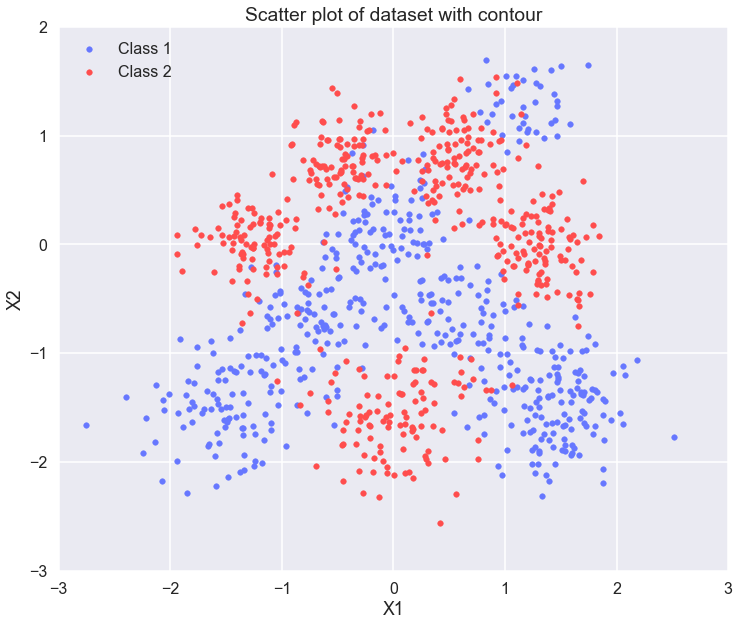

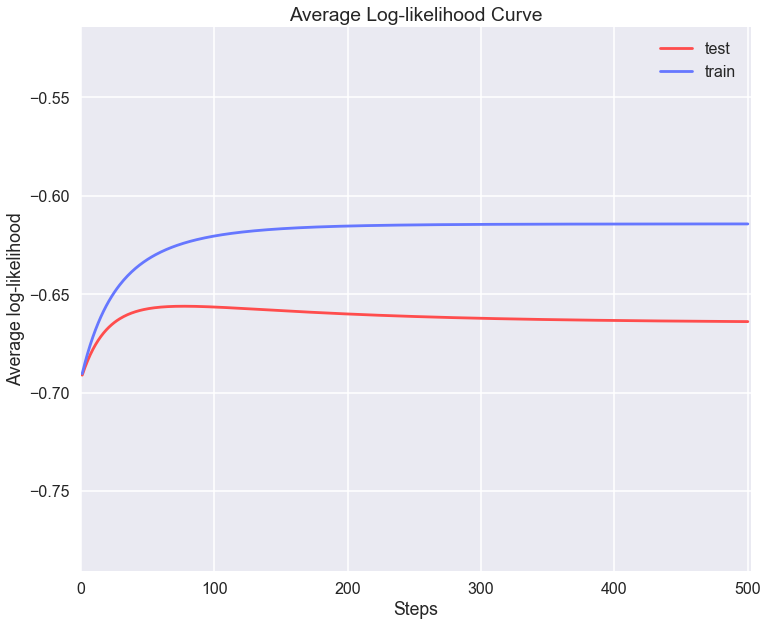

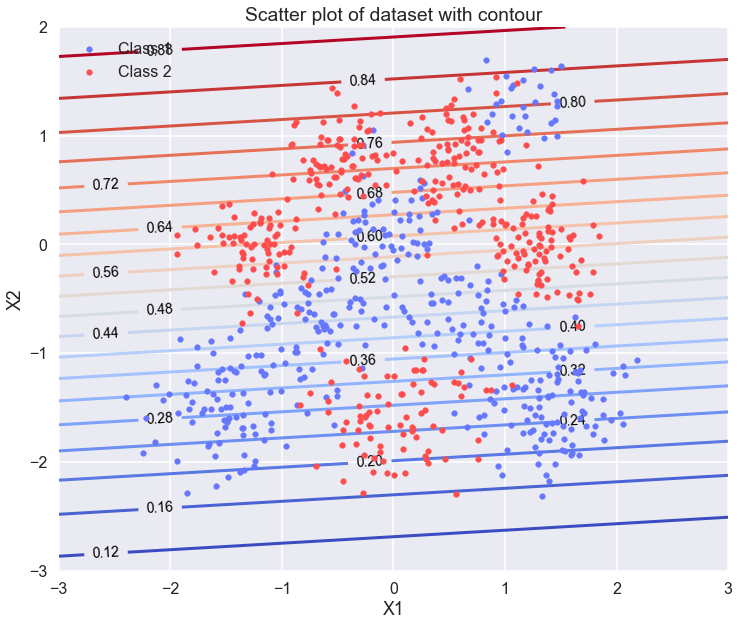

array([[0.35, 0.17],
       [0.15, 0.33]])

In [3]:
model = LogisticRegression(lr=1e-4, num_iter=500, split=0.2)
model.fit(X, y)

preds = model.predict_prob(model.X_train)

model.plot_data_internal(X,y)

model.plot_ll()

model.plot_contour(model.X_train, model.X_train_plot, model.y_train)

#model.confusion(model.X_train, model.y_train)

model.confusion(model.X_test, model.y_test)

0.0005000115525864696
1.3425241896820144
test=-0.6644897434303029
train=-0.047897397552972704
CPU times: user 1min 12s, sys: 4.63 s, total: 1min 16s
Wall time: 53.5 s


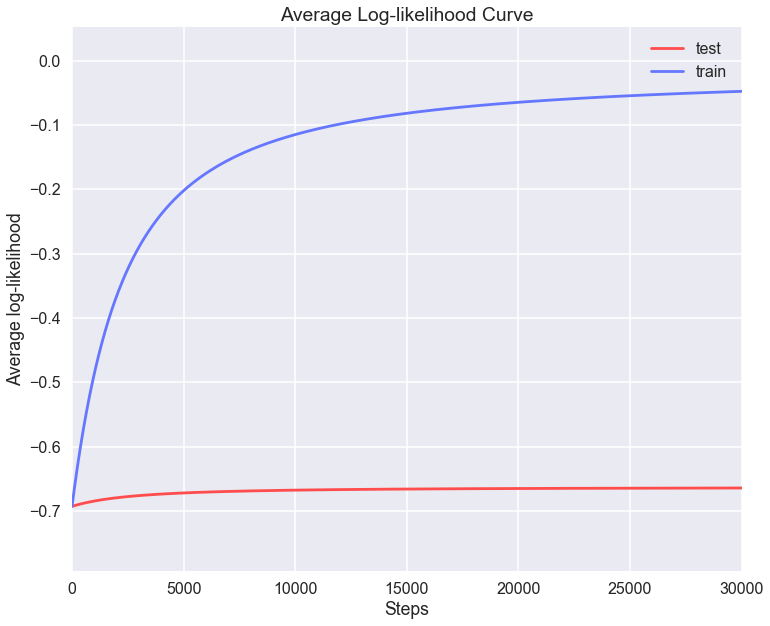

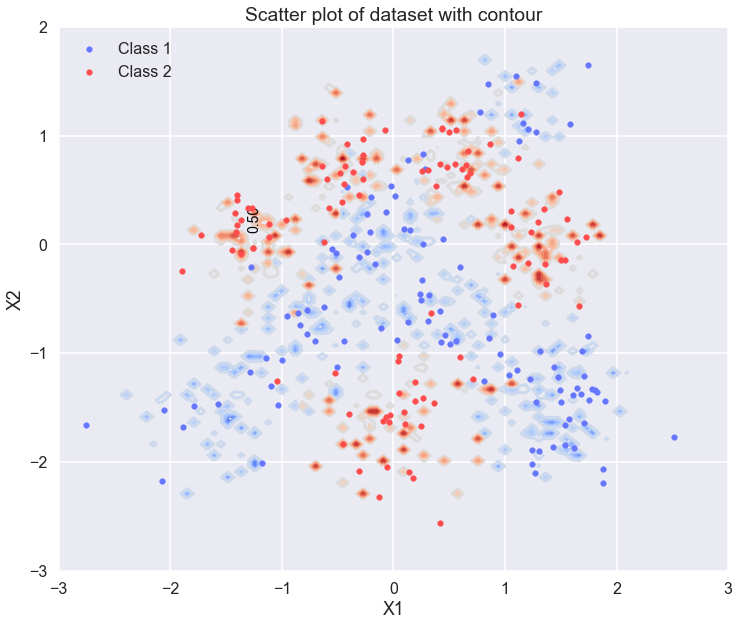

[[0.5025 0.    ]
 [0.     0.4975]]
[[0.505 0.015]
 [0.405 0.075]]


In [4]:
model_rbf = LogisticRegression(lr=1e-3, num_iter=30000, rbf_length=0.01, split=0.2)
%time model_rbf.fit(X, y)

model_rbf.plot_ll()

model_rbf.plot_contour(model_rbf.X_test, model_rbf.X_test_plot, model_rbf.y_test)

print(model_rbf.confusion(model_rbf.X_train, model_rbf.y_train))

print(model_rbf.confusion(model_rbf.X_test, model_rbf.y_test))

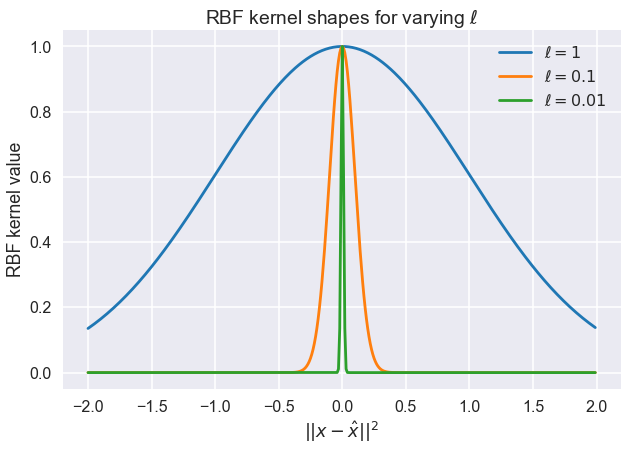

In [5]:
x = np.arange(-2,2, 0.01)

def rbf(x, l):
    
    return np.exp((-0.5/l**2) * x**2)

y1 = rbf(x,1)
y01 = rbf(x,0.1)
y001 = rbf(x,0.01)

plt.figure(figsize=(10,6.6))
plt.plot(x,y1, label=r'$\ell=1$')
plt.plot(x,y01, label=r'$\ell=0.1$')
plt.plot(x,y001, label=r'$\ell=0.01$')
plt.legend()
plt.xlabel(r'$||x-\hat{x}||^{2}$')
plt.ylabel("RBF kernel value")
plt.title("RBF kernel shapes for varying " + r'$\ell$')

plt.show()

In [6]:
print(model_rbf.theta[0])

-0.09427807442216515


# FTR

Laplace approximation involves taking a Gaussian prior over the model parameters with zero mean and variance $ \sigma_{0}^{2} $:

0.0005001155378770384
0.3227381971965512
test=-0.31043312327178024
train=-0.21544675835203436
CPU times: user 5min 21s, sys: 15.1 s, total: 5min 36s
Wall time: 5min 10s


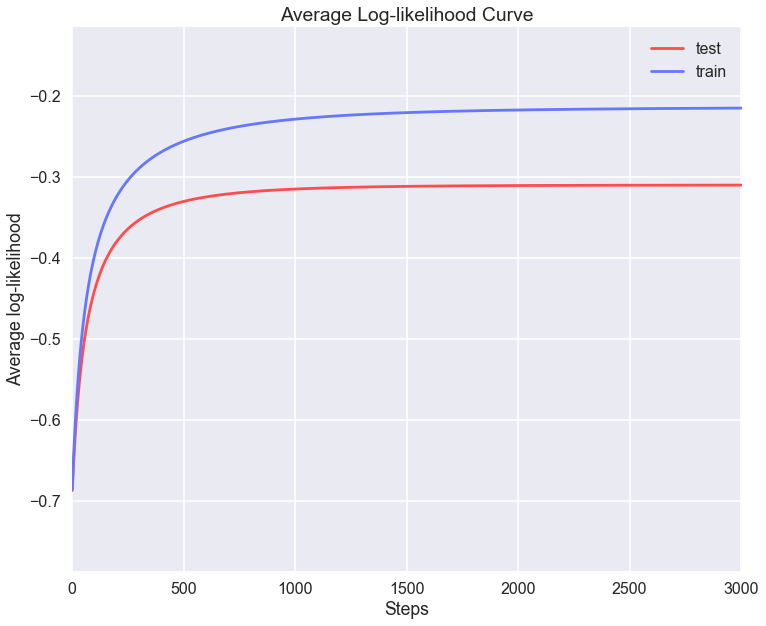

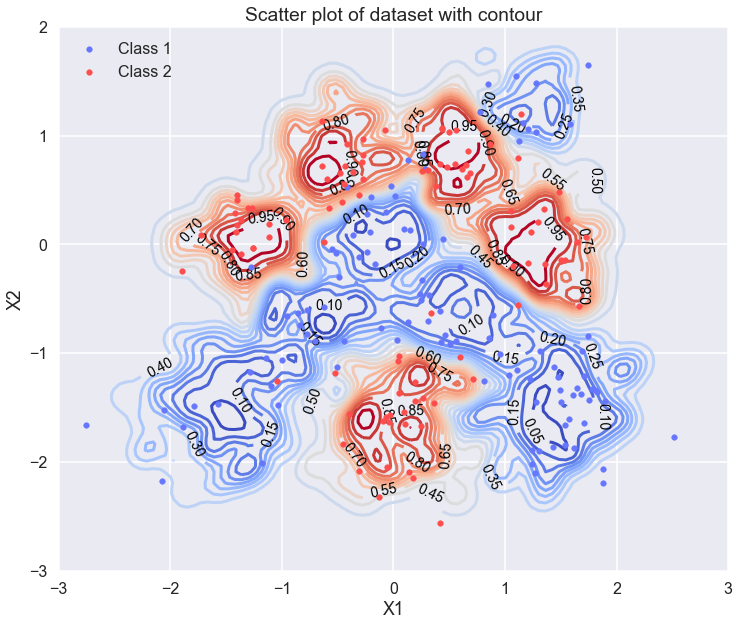

In [9]:
model_approx = LogisticRegression(lr=1e-3, num_iter=3000, rbf_length=0.1, split=0.2, laplace=True)

# Calculating the MAP estimate to be used as the mean of the Gaussian   
                      
%time model_approx.fit(X, y)



model_approx.plot_ll()

model_approx.plot_contour(model_approx.X_test, model_approx.X_test_plot, model_approx.y_test)

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000, fit_intercept=True, split=0.5, rbf_length=None, laplace=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.train_history = []
        self.test_history = []
        self.split = split
        self.rbf_length = rbf_length
        self.laplace = laplace
    
    def __add_intercept(self, X):
        
        intercept = np.ones((X.shape[0], 1))
        
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def __expand(self, X, Z, l):
        X2 = np.sum(X**2, 1)
        Z2 = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])
        r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
        return np.exp((-0.5 / l**2) * r2)
    
    def fit(self, X, y):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.split, random_state=40)
        
        self.X_train_plot = self.X_train.copy()
        self.X_test_plot = self.X_test.copy()
        
        if not self.rbf_length == None:
            self.X_test = self.__expand(self.X_test, self.X_train, self.rbf_length)
            self.X_train = self.__expand(self.X_train, self.X_train, self.rbf_length)
            
        if self.fit_intercept:
            self.X_train = self.__add_intercept(self.X_train)
            self.X_test = self.__add_intercept(self.X_test)
        
        # Initialise weights as zeros
        self.theta = np.zeros(self.X_train.shape[1])
        
        if self.laplace:
            self.prior = (np.zeros(self.theta.shape), np.identity(self.theta.shape[0]))
        
        # Carry out gradient ascent for defined number of iterations
        for i in range(self.num_iter):
            z = np.dot(self.X_train, self.theta)
            h = self.__sigmoid(z)
            if self.laplace:
                gradient = np.matmul(np.linalg.inv(self.prior[1]), (self.prior[0] - self.theta)) + np.matmul(self.X_train.T, (self.y_train - h))
            else:
                gradient = np.matmul(self.X_train.T, (self.y_train - h))
            lr = self.lr * (0.5**(i/self.num_iter))
            self.theta += lr * gradient
            #print(self.lr)
            self.test_history.append(self.compute_ll(self.X_test, self.y_test))
            self.train_history.append(self.compute_ll(self.X_train, self.y_train))
            
        if self.laplace:
            
        
        print(lr)
        print(np.linalg.norm(gradient))
        print("test="+str(self.test_history[-1]))
        print("train="+str(self.train_history[-1]))
    
    def predict_prob(self, X):
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def compute_ll(self, X, y):
            
        output_prob = self.predict_prob(X)
            
        return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1 - output_prob))
    
    def plot_ll(self):
        ll = self.test_history
        ll2 = self.train_history
        plt.figure(figsize=(12,10))
        ax = plt.gca()
        plt.xlim(0, len(ll) + 2)
        plt.ylim(min(ll2) - 0.1, max(ll2) + 0.1)
        ax.plot(np.arange(1, len(ll) + 1), ll, '#ff4d4d', label="test")
        ax.plot(np.arange(1, len(ll2) + 1), ll2, '#6677ff', label="train")
        plt.xlabel('Steps')
        plt.ylabel('Average log-likelihood')
        plt.title('Average Log-likelihood Curve')
        plt.legend()
        plt.show()
        
    def plot_data_internal(self, X, y):
        x_min, x_max = -3, 3
        y_min, y_max = -3, 2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        plt.figure(figsize=(12,10))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        ax = plt.gca()
        ax.scatter(X[y == 0, 0], X[y == 0, 1], color='#6677ff', marker='.', label = 'Class 1', zorder=5)
        ax.scatter(X[y == 1, 0], X[y == 1, 1], color='#ff4d4d', marker='.', label = 'Class 2', zorder=10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Scatter plot of dataset with contour')
        plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
        return xx, yy
        
    def plot_contour(self, X, plot, y):
        xx, yy = self.plot_data_internal(plot, y)
        ax = plt.gca()
            
        X_predict = np.concatenate((xx.ravel().reshape((-1, 1)),
                                    yy.ravel().reshape((-1, 1))), 1)
        
        if not self.rbf_length == None:
            X_predict = self.__expand(X_predict, self.X_train_plot, self.rbf_length)
        
        X_predict = np.concatenate((np.ones((X_predict.shape[0], 1)), X_predict), 1)
        
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)
        
        Z = self.predict_prob(X_predict)
        Z = Z.reshape(xx.shape)
        cs2 = ax.contour(xx, yy, Z, 20, cmap = 'coolwarm', linewidths = 3, zorder=1)
        plt.clabel(cs2, fmt = '%2.2f', colors = 'k', fontsize = 14)
        plt.show()
        
    def confusion(self, X, y):
        
        preds = self.predict(X, 0.5)
        
        return confusion_matrix(y, preds, labels=[False, True]) / len(y)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold